# Face Generation
In this project, we use generative adversarial networks (GANs) to generate new images of faces.
### Get the Data
Using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = '~/data'
data_dir = '/home/thojo/work/ud/deep-learning/face_generation/data'
import helper
import pickle as pkl
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

In [2]:
# """
# DON'T MODIFY ANYTHING IN THIS CELL
# """


# helper.download_extract('mnist', data_dir)
# helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

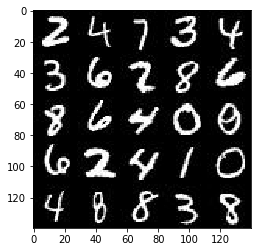

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

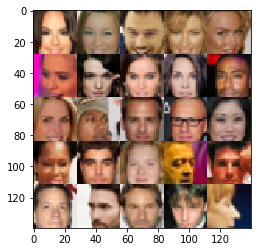

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/thojo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim ):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # done: implement function
    with tf.variable_scope('discriminator', reuse=reuse):
            # Input layer is 28x28x1 for MNIST and celebA
            
            x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same') 
            # no batch_normalization in the first layer
            lrelu1 = tf.maximum( alpha*x1, x1)
            # now 14x14x64

            x2 = tf.layers.conv2d(lrelu1, 128, 5, strides = 2, padding = 'same')
            bn2 = tf.layers.batch_normalization( x2, training = True )
            lrelu2 = tf.maximum( alpha*bn2, bn2)
            # now 7x7x128

            x3 = tf.layers.conv2d(lrelu1, 256, 5, strides = 2, padding = 'same')
            bn3 = tf.layers.batch_normalization( x3, training = True )
            lrelu3 = tf.maximum( alpha*bn3, bn3)
            # now 4x4x256

            flat = tf.reshape( lrelu3,(-1,4*4*256) ) 
            logits = tf.layers.dense( flat, 1 )
            out = tf.sigmoid( logits )

            return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):   
        # Fully connected
        x1 = tf.layers.dense(z, 2*2*256)
        # Reshape first layer as 2x2x256
        x1 = tf.reshape(x1, (-1, 2, 2, 256))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum( alpha*x1, x1) #leaky relu

        # Second layer as (7x7x128)
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='VALID')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum( alpha*x2, x2) #leaky relu
        
        # Third layer as (14x14x64)
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum( alpha*x3, x3) #leaky relu

        # Ouput layer as (28x28x out_channel_dim)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME')
        out = tf.tanh(logits)

    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim ):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim )
    d_model_real, d_logits_real = discriminator( input_real, reuse = False )
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True )

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize, controlling dependencies approporiately
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate_scalar, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim )
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1 )
 
    saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0
    print_every = 500
    show_every = 5 * print_every 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            # Train Model
            for batch_images in get_batches(batch_size):
                batch_images  = batch_images * 2
                steps += 1
                # Sample random noise for G 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run( d_opt, feed_dict={ input_real: batch_images, input_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run( g_opt, feed_dict={ input_z: batch_z, input_real: batch_images, learning_rate: learning_rate_scalar})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({ input_z: batch_z, input_real: batch_images, learning_rate: learning_rate_scalar })
                    train_loss_g = g_loss.eval({ input_z: batch_z, learning_rate: learning_rate_scalar})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/100... Discriminator Loss: 0.3395... Generator Loss: 2.1049
Epoch 2/100... Discriminator Loss: 0.2874... Generator Loss: 2.2994
Epoch 2/100... Discriminator Loss: 0.2871... Generator Loss: 2.2225
Epoch 3/100... Discriminator Loss: 0.2477... Generator Loss: 2.4507
Epoch 3/100... Discriminator Loss: 0.5222... Generator Loss: 3.3665


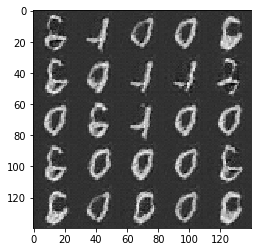

Epoch 4/100... Discriminator Loss: 0.3414... Generator Loss: 2.8086
Epoch 4/100... Discriminator Loss: 0.2356... Generator Loss: 3.8764
Epoch 5/100... Discriminator Loss: 0.8790... Generator Loss: 2.4616
Epoch 5/100... Discriminator Loss: 0.2377... Generator Loss: 2.6611
Epoch 6/100... Discriminator Loss: 0.1901... Generator Loss: 2.7014


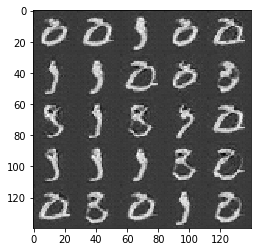

Epoch 6/100... Discriminator Loss: 0.3827... Generator Loss: 2.8879
Epoch 7/100... Discriminator Loss: 0.2379... Generator Loss: 2.3378
Epoch 7/100... Discriminator Loss: 0.3241... Generator Loss: 2.1828
Epoch 8/100... Discriminator Loss: 0.4620... Generator Loss: 2.8313
Epoch 9/100... Discriminator Loss: 0.2284... Generator Loss: 3.0893


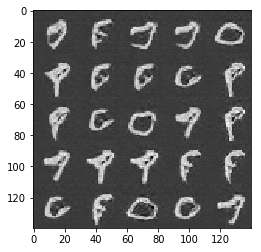

Epoch 9/100... Discriminator Loss: 0.2482... Generator Loss: 3.0074
Epoch 10/100... Discriminator Loss: 0.3435... Generator Loss: 2.8069
Epoch 10/100... Discriminator Loss: 0.1899... Generator Loss: 2.7745
Epoch 11/100... Discriminator Loss: 0.1269... Generator Loss: 3.0870
Epoch 11/100... Discriminator Loss: 0.6540... Generator Loss: 4.7520


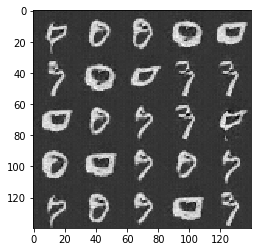

Epoch 12/100... Discriminator Loss: 0.2485... Generator Loss: 2.7365
Epoch 12/100... Discriminator Loss: 0.2430... Generator Loss: 3.0063
Epoch 13/100... Discriminator Loss: 0.4601... Generator Loss: 1.8941
Epoch 13/100... Discriminator Loss: 0.2545... Generator Loss: 2.5687
Epoch 14/100... Discriminator Loss: 0.3348... Generator Loss: 2.9475


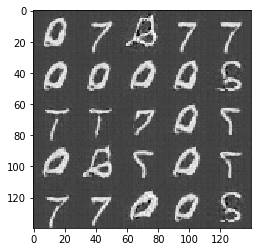

Epoch 14/100... Discriminator Loss: 0.2567... Generator Loss: 3.5439
Epoch 15/100... Discriminator Loss: 1.3553... Generator Loss: 2.8238
Epoch 15/100... Discriminator Loss: 0.1806... Generator Loss: 3.3703
Epoch 16/100... Discriminator Loss: 0.4975... Generator Loss: 2.9692
Epoch 17/100... Discriminator Loss: 0.4635... Generator Loss: 1.8016


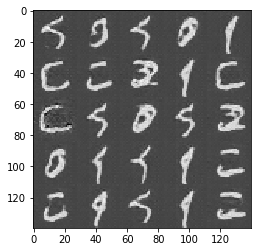

Epoch 17/100... Discriminator Loss: 0.2298... Generator Loss: 2.5446
Epoch 18/100... Discriminator Loss: 0.5185... Generator Loss: 2.4951
Epoch 18/100... Discriminator Loss: 0.5759... Generator Loss: 3.6344
Epoch 19/100... Discriminator Loss: 0.4056... Generator Loss: 2.2913
Epoch 19/100... Discriminator Loss: 0.2548... Generator Loss: 3.4418


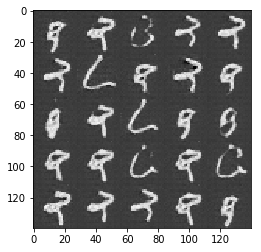

Epoch 20/100... Discriminator Loss: 0.3197... Generator Loss: 3.3993
Epoch 20/100... Discriminator Loss: 0.7914... Generator Loss: 4.3879
Epoch 21/100... Discriminator Loss: 0.3993... Generator Loss: 3.4706
Epoch 21/100... Discriminator Loss: 0.2979... Generator Loss: 2.6481
Epoch 22/100... Discriminator Loss: 0.2869... Generator Loss: 2.6674


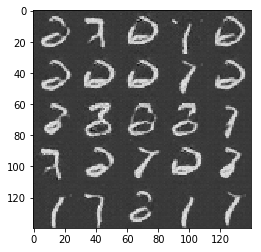

Epoch 22/100... Discriminator Loss: 0.5234... Generator Loss: 3.2979
Epoch 23/100... Discriminator Loss: 0.1275... Generator Loss: 3.5738
Epoch 23/100... Discriminator Loss: 0.2938... Generator Loss: 3.1540
Epoch 24/100... Discriminator Loss: 0.2694... Generator Loss: 3.3452
Epoch 25/100... Discriminator Loss: 0.2922... Generator Loss: 3.5520


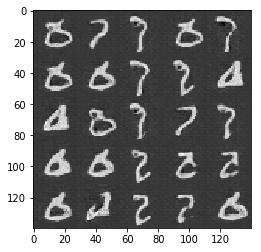

Epoch 25/100... Discriminator Loss: 0.2147... Generator Loss: 3.0373
Epoch 26/100... Discriminator Loss: 0.3803... Generator Loss: 3.5022
Epoch 26/100... Discriminator Loss: 0.3155... Generator Loss: 4.3819
Epoch 27/100... Discriminator Loss: 0.1904... Generator Loss: 3.5860
Epoch 27/100... Discriminator Loss: 0.1427... Generator Loss: 3.3742


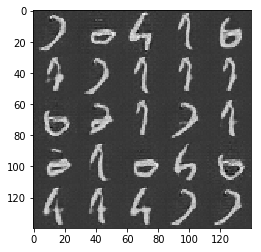

Epoch 28/100... Discriminator Loss: 0.1557... Generator Loss: 3.5330
Epoch 28/100... Discriminator Loss: 0.6454... Generator Loss: 5.8427
Epoch 29/100... Discriminator Loss: 0.2188... Generator Loss: 3.2972
Epoch 29/100... Discriminator Loss: 0.2030... Generator Loss: 4.2469
Epoch 30/100... Discriminator Loss: 0.1081... Generator Loss: 3.9808


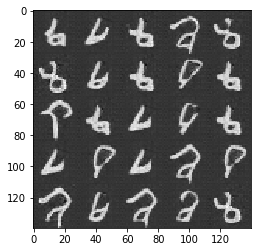

Epoch 30/100... Discriminator Loss: 0.6856... Generator Loss: 3.3428
Epoch 31/100... Discriminator Loss: 0.1255... Generator Loss: 4.1011
Epoch 31/100... Discriminator Loss: 0.3281... Generator Loss: 2.6202
Epoch 32/100... Discriminator Loss: 0.7205... Generator Loss: 3.1285
Epoch 33/100... Discriminator Loss: 0.1473... Generator Loss: 4.1475


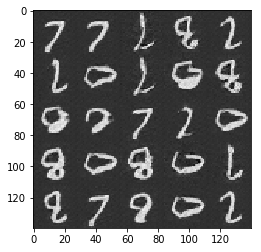

Epoch 33/100... Discriminator Loss: 0.0929... Generator Loss: 4.3125
Epoch 34/100... Discriminator Loss: 0.2801... Generator Loss: 2.8162
Epoch 34/100... Discriminator Loss: 0.2683... Generator Loss: 4.3961
Epoch 35/100... Discriminator Loss: 0.2446... Generator Loss: 3.0595
Epoch 35/100... Discriminator Loss: 0.2352... Generator Loss: 2.6102


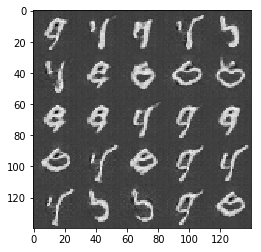

Epoch 36/100... Discriminator Loss: 0.6523... Generator Loss: 3.8429
Epoch 36/100... Discriminator Loss: 0.0898... Generator Loss: 3.8180
Epoch 37/100... Discriminator Loss: 0.1910... Generator Loss: 3.5404
Epoch 37/100... Discriminator Loss: 0.1316... Generator Loss: 3.8329
Epoch 38/100... Discriminator Loss: 0.1563... Generator Loss: 3.3687


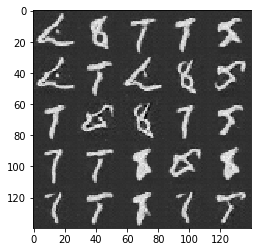

Epoch 38/100... Discriminator Loss: 0.1038... Generator Loss: 3.8763
Epoch 39/100... Discriminator Loss: 0.0794... Generator Loss: 3.8049
Epoch 39/100... Discriminator Loss: 0.2089... Generator Loss: 2.8793
Epoch 40/100... Discriminator Loss: 0.1736... Generator Loss: 3.4912
Epoch 41/100... Discriminator Loss: 0.2528... Generator Loss: 3.6029


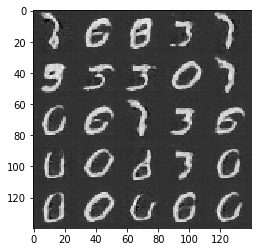

Epoch 41/100... Discriminator Loss: 0.2071... Generator Loss: 2.8566
Epoch 42/100... Discriminator Loss: 0.1647... Generator Loss: 3.8795
Epoch 42/100... Discriminator Loss: 0.1477... Generator Loss: 3.6820
Epoch 43/100... Discriminator Loss: 0.2720... Generator Loss: 2.9681
Epoch 43/100... Discriminator Loss: 0.2781... Generator Loss: 3.0909


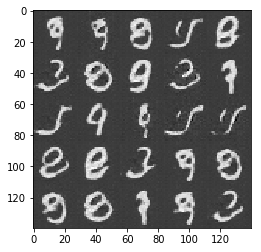

Epoch 44/100... Discriminator Loss: 0.5423... Generator Loss: 3.4470
Epoch 44/100... Discriminator Loss: 0.1353... Generator Loss: 3.4234
Epoch 45/100... Discriminator Loss: 0.2037... Generator Loss: 2.7775
Epoch 45/100... Discriminator Loss: 0.2653... Generator Loss: 3.1652
Epoch 46/100... Discriminator Loss: 1.6889... Generator Loss: 3.2829


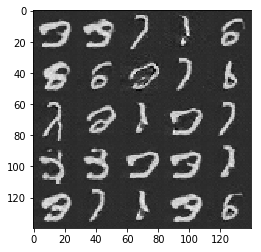

Epoch 46/100... Discriminator Loss: 0.3165... Generator Loss: 2.6226
Epoch 47/100... Discriminator Loss: 0.2131... Generator Loss: 4.0666
Epoch 47/100... Discriminator Loss: 0.1117... Generator Loss: 4.5101
Epoch 48/100... Discriminator Loss: 0.1201... Generator Loss: 3.3568
Epoch 49/100... Discriminator Loss: 0.1339... Generator Loss: 5.5358


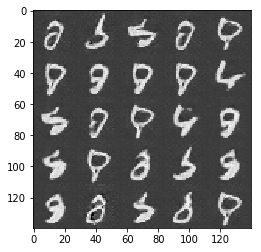

Epoch 49/100... Discriminator Loss: 0.3437... Generator Loss: 6.5399
Epoch 50/100... Discriminator Loss: 0.0831... Generator Loss: 5.3685
Epoch 50/100... Discriminator Loss: 0.1303... Generator Loss: 3.7144
Epoch 51/100... Discriminator Loss: 0.1026... Generator Loss: 4.2489
Epoch 51/100... Discriminator Loss: 0.0927... Generator Loss: 3.8904


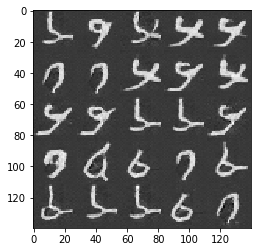

Epoch 52/100... Discriminator Loss: 0.3198... Generator Loss: 3.3356
Epoch 52/100... Discriminator Loss: 0.1113... Generator Loss: 4.2375
Epoch 53/100... Discriminator Loss: 0.2069... Generator Loss: 2.5911
Epoch 53/100... Discriminator Loss: 0.1303... Generator Loss: 3.0497
Epoch 54/100... Discriminator Loss: 0.1428... Generator Loss: 3.9741


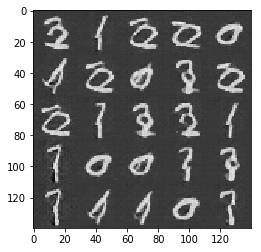

Epoch 54/100... Discriminator Loss: 0.1191... Generator Loss: 6.3581
Epoch 55/100... Discriminator Loss: 0.1103... Generator Loss: 5.1833
Epoch 55/100... Discriminator Loss: 0.0513... Generator Loss: 4.4347
Epoch 56/100... Discriminator Loss: 0.4636... Generator Loss: 5.4415
Epoch 57/100... Discriminator Loss: 0.0872... Generator Loss: 4.5538


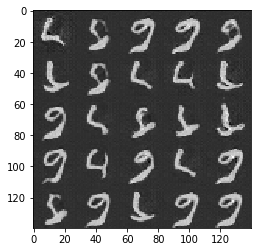

Epoch 57/100... Discriminator Loss: 0.0983... Generator Loss: 3.8153
Epoch 58/100... Discriminator Loss: 0.4898... Generator Loss: 6.8003
Epoch 58/100... Discriminator Loss: 0.2852... Generator Loss: 3.1194
Epoch 59/100... Discriminator Loss: 0.1269... Generator Loss: 4.1659
Epoch 59/100... Discriminator Loss: 0.2546... Generator Loss: 2.9613


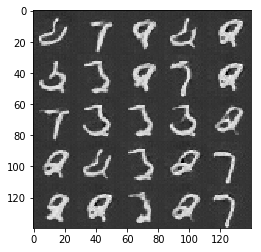

Epoch 60/100... Discriminator Loss: 0.0975... Generator Loss: 4.6707
Epoch 60/100... Discriminator Loss: 0.1371... Generator Loss: 3.2666
Epoch 61/100... Discriminator Loss: 0.1287... Generator Loss: 3.6389
Epoch 61/100... Discriminator Loss: 0.0694... Generator Loss: 4.3417
Epoch 62/100... Discriminator Loss: 0.1836... Generator Loss: 3.7163


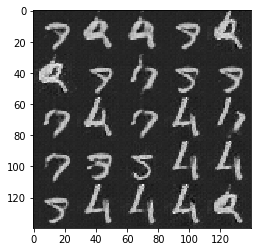

Epoch 62/100... Discriminator Loss: 0.0740... Generator Loss: 5.1645
Epoch 63/100... Discriminator Loss: 0.0246... Generator Loss: 5.5903
Epoch 63/100... Discriminator Loss: 0.0554... Generator Loss: 4.4678
Epoch 64/100... Discriminator Loss: 0.0406... Generator Loss: 4.9068
Epoch 65/100... Discriminator Loss: 0.0158... Generator Loss: 6.4945


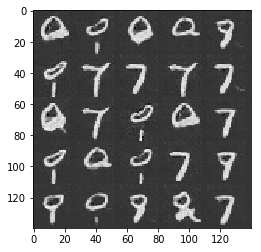

Epoch 65/100... Discriminator Loss: 0.8841... Generator Loss: 3.3495
Epoch 66/100... Discriminator Loss: 0.0651... Generator Loss: 4.1168
Epoch 66/100... Discriminator Loss: 0.1333... Generator Loss: 4.4638
Epoch 67/100... Discriminator Loss: 0.0232... Generator Loss: 7.7575
Epoch 67/100... Discriminator Loss: 0.0866... Generator Loss: 4.3109


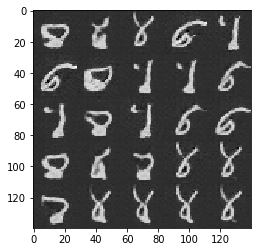

Epoch 68/100... Discriminator Loss: 0.0819... Generator Loss: 4.3547
Epoch 68/100... Discriminator Loss: 0.0580... Generator Loss: 5.9443
Epoch 69/100... Discriminator Loss: 0.0780... Generator Loss: 4.1042
Epoch 69/100... Discriminator Loss: 0.0454... Generator Loss: 4.2745
Epoch 70/100... Discriminator Loss: 0.1840... Generator Loss: 3.4250


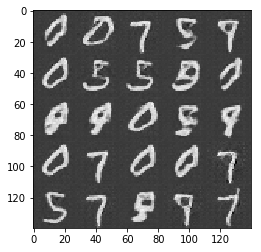

Epoch 70/100... Discriminator Loss: 0.0903... Generator Loss: 4.1687
Epoch 71/100... Discriminator Loss: 0.0525... Generator Loss: 6.7422
Epoch 71/100... Discriminator Loss: 0.0718... Generator Loss: 5.2062
Epoch 72/100... Discriminator Loss: 0.0989... Generator Loss: 3.9779
Epoch 73/100... Discriminator Loss: 0.0925... Generator Loss: 4.9959


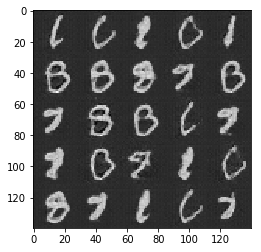

Epoch 73/100... Discriminator Loss: 0.0994... Generator Loss: 4.8780
Epoch 74/100... Discriminator Loss: 0.0924... Generator Loss: 5.3480
Epoch 74/100... Discriminator Loss: 0.0599... Generator Loss: 4.8938
Epoch 75/100... Discriminator Loss: 0.1742... Generator Loss: 5.1140
Epoch 75/100... Discriminator Loss: 0.1190... Generator Loss: 4.9417


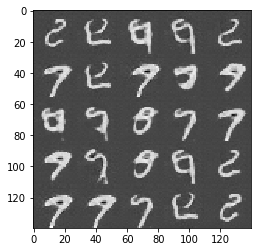

Epoch 76/100... Discriminator Loss: 0.2223... Generator Loss: 4.4162
Epoch 76/100... Discriminator Loss: 0.0218... Generator Loss: 6.4567
Epoch 77/100... Discriminator Loss: 0.0290... Generator Loss: 5.2604
Epoch 77/100... Discriminator Loss: 2.9319... Generator Loss: 12.2074
Epoch 78/100... Discriminator Loss: 0.0979... Generator Loss: 5.3195


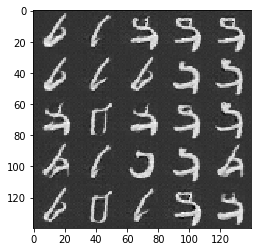

Epoch 78/100... Discriminator Loss: 0.1083... Generator Loss: 4.5555
Epoch 79/100... Discriminator Loss: 0.0541... Generator Loss: 6.6357
Epoch 79/100... Discriminator Loss: 0.0981... Generator Loss: 4.3869
Epoch 80/100... Discriminator Loss: 0.1340... Generator Loss: 3.3552
Epoch 81/100... Discriminator Loss: 0.0591... Generator Loss: 4.1658


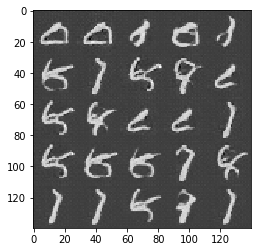

Epoch 81/100... Discriminator Loss: 0.0791... Generator Loss: 4.6431
Epoch 82/100... Discriminator Loss: 0.0519... Generator Loss: 4.7891
Epoch 82/100... Discriminator Loss: 0.0539... Generator Loss: 4.8576
Epoch 83/100... Discriminator Loss: 0.1072... Generator Loss: 3.6256
Epoch 83/100... Discriminator Loss: 0.1331... Generator Loss: 4.0719


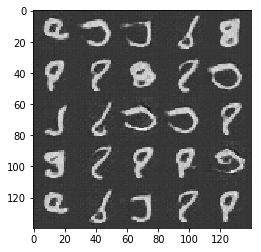

Epoch 84/100... Discriminator Loss: 0.0644... Generator Loss: 4.5445
Epoch 84/100... Discriminator Loss: 0.0709... Generator Loss: 5.3137
Epoch 85/100... Discriminator Loss: 0.1581... Generator Loss: 3.5506
Epoch 85/100... Discriminator Loss: 0.0235... Generator Loss: 6.3750
Epoch 86/100... Discriminator Loss: 0.2285... Generator Loss: 5.3662


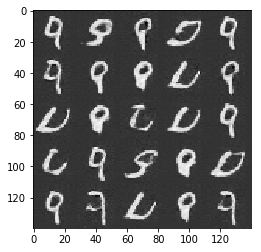

Epoch 86/100... Discriminator Loss: 0.0224... Generator Loss: 5.8265
Epoch 87/100... Discriminator Loss: 0.1209... Generator Loss: 4.3170
Epoch 87/100... Discriminator Loss: 0.0829... Generator Loss: 4.4101
Epoch 88/100... Discriminator Loss: 0.0765... Generator Loss: 4.2973
Epoch 89/100... Discriminator Loss: 0.0746... Generator Loss: 4.0927


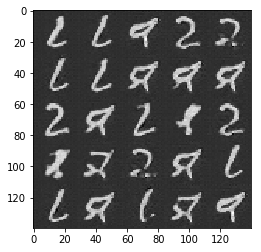

Epoch 89/100... Discriminator Loss: 0.1139... Generator Loss: 5.5971
Epoch 90/100... Discriminator Loss: 0.0815... Generator Loss: 4.3965
Epoch 90/100... Discriminator Loss: 0.0920... Generator Loss: 3.9124
Epoch 91/100... Discriminator Loss: 1.3124... Generator Loss: 7.3515
Epoch 91/100... Discriminator Loss: 0.1999... Generator Loss: 3.3559


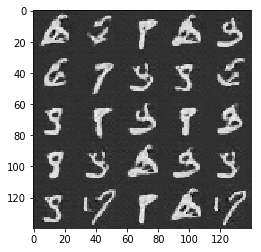

Epoch 92/100... Discriminator Loss: 0.0699... Generator Loss: 4.7959
Epoch 92/100... Discriminator Loss: 0.0513... Generator Loss: 5.2868
Epoch 93/100... Discriminator Loss: 0.0381... Generator Loss: 5.4356
Epoch 93/100... Discriminator Loss: 0.2101... Generator Loss: 5.4885
Epoch 94/100... Discriminator Loss: 0.1150... Generator Loss: 5.2726


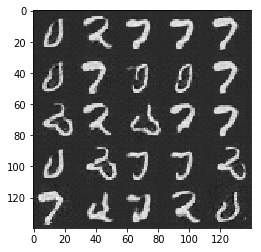

Epoch 94/100... Discriminator Loss: 0.1978... Generator Loss: 6.6173
Epoch 95/100... Discriminator Loss: 0.0366... Generator Loss: 5.2222
Epoch 95/100... Discriminator Loss: 0.0338... Generator Loss: 6.4580
Epoch 96/100... Discriminator Loss: 0.0361... Generator Loss: 5.5506
Epoch 97/100... Discriminator Loss: 0.0990... Generator Loss: 4.3019


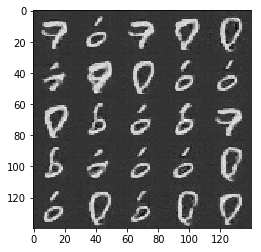

Epoch 97/100... Discriminator Loss: 0.0596... Generator Loss: 4.6534
Epoch 98/100... Discriminator Loss: 0.0679... Generator Loss: 4.5412
Epoch 98/100... Discriminator Loss: 0.0956... Generator Loss: 4.8754
Epoch 99/100... Discriminator Loss: 0.1040... Generator Loss: 4.1044
Epoch 99/100... Discriminator Loss: 0.0198... Generator Loss: 5.4133


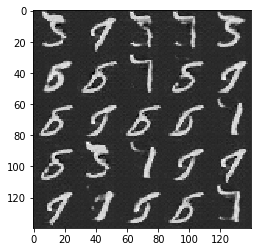

Epoch 100/100... Discriminator Loss: 0.1341... Generator Loss: 5.0379
Epoch 100/100... Discriminator Loss: 0.1270... Generator Loss: 3.4900


In [15]:
batch_size = 64 #needs to be a factor of 4096
z_dim = 100
learning_rate = 0.001
beta1 = 0.6

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 100

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, 
          mnist_dataset.image_mode)

I notice here (and also while running on AWS) that the generator loss oscillates a little at first, but then settles around 3.0-4.0.

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/100... Discriminator Loss: 0.8786... Generator Loss: 1.0327
Epoch 1/100... Discriminator Loss: 1.0171... Generator Loss: 0.9570
Epoch 1/100... Discriminator Loss: 1.1679... Generator Loss: 1.1025
Epoch 1/100... Discriminator Loss: 1.1521... Generator Loss: 1.0525
Epoch 1/100... Discriminator Loss: 1.1891... Generator Loss: 0.7616


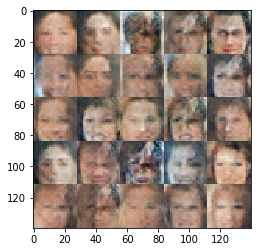

Epoch 1/100... Discriminator Loss: 1.1558... Generator Loss: 0.8740
Epoch 2/100... Discriminator Loss: 1.1987... Generator Loss: 0.8594
Epoch 2/100... Discriminator Loss: 1.2251... Generator Loss: 0.8598
Epoch 2/100... Discriminator Loss: 1.2712... Generator Loss: 0.8404
Epoch 2/100... Discriminator Loss: 1.3535... Generator Loss: 0.9215


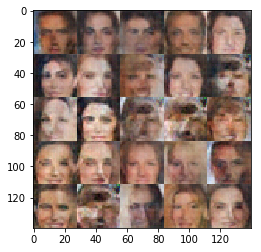

Epoch 2/100... Discriminator Loss: 1.3433... Generator Loss: 0.7197
Epoch 2/100... Discriminator Loss: 1.3159... Generator Loss: 0.8255
Epoch 3/100... Discriminator Loss: 1.2171... Generator Loss: 0.8041
Epoch 3/100... Discriminator Loss: 1.3076... Generator Loss: 0.7100
Epoch 3/100... Discriminator Loss: 1.2659... Generator Loss: 0.7529


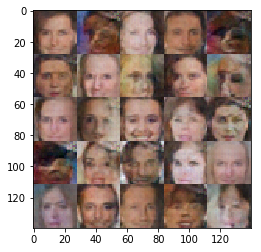

Epoch 3/100... Discriminator Loss: 1.3542... Generator Loss: 0.6792
Epoch 3/100... Discriminator Loss: 1.2496... Generator Loss: 0.7618
Epoch 3/100... Discriminator Loss: 1.3068... Generator Loss: 0.7867
Epoch 4/100... Discriminator Loss: 1.2839... Generator Loss: 0.8370
Epoch 4/100... Discriminator Loss: 1.3473... Generator Loss: 0.7240


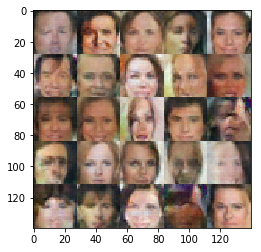

Epoch 4/100... Discriminator Loss: 1.3467... Generator Loss: 0.7479
Epoch 4/100... Discriminator Loss: 1.2957... Generator Loss: 0.7883
Epoch 4/100... Discriminator Loss: 1.3563... Generator Loss: 0.6983
Epoch 4/100... Discriminator Loss: 1.3218... Generator Loss: 0.7918
Epoch 4/100... Discriminator Loss: 1.4726... Generator Loss: 0.8106


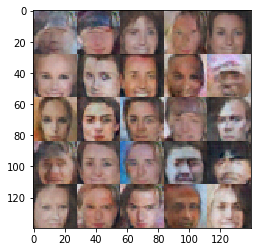

Epoch 5/100... Discriminator Loss: 1.2955... Generator Loss: 0.7435
Epoch 5/100... Discriminator Loss: 1.3213... Generator Loss: 0.7201
Epoch 5/100... Discriminator Loss: 1.3302... Generator Loss: 0.7467
Epoch 5/100... Discriminator Loss: 1.2212... Generator Loss: 0.7851
Epoch 5/100... Discriminator Loss: 1.2300... Generator Loss: 0.8327


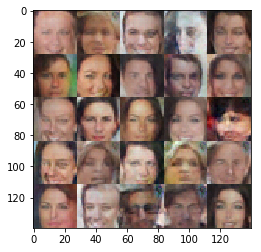

Epoch 5/100... Discriminator Loss: 1.2694... Generator Loss: 0.7789
Epoch 6/100... Discriminator Loss: 1.3119... Generator Loss: 0.7653
Epoch 6/100... Discriminator Loss: 1.2094... Generator Loss: 0.8355
Epoch 6/100... Discriminator Loss: 1.2866... Generator Loss: 0.7405
Epoch 6/100... Discriminator Loss: 1.2442... Generator Loss: 0.8334


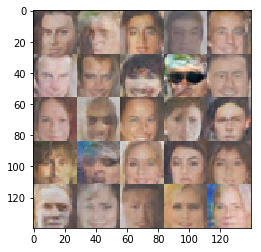

Epoch 6/100... Discriminator Loss: 1.3052... Generator Loss: 0.7586
Epoch 6/100... Discriminator Loss: 1.3915... Generator Loss: 0.7520
Epoch 7/100... Discriminator Loss: 1.3801... Generator Loss: 0.7410
Epoch 7/100... Discriminator Loss: 1.2574... Generator Loss: 0.8561
Epoch 7/100... Discriminator Loss: 1.3515... Generator Loss: 0.8453


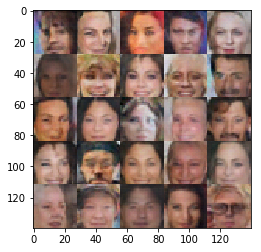

Epoch 7/100... Discriminator Loss: 1.2830... Generator Loss: 0.7670
Epoch 7/100... Discriminator Loss: 1.2722... Generator Loss: 0.7320
Epoch 7/100... Discriminator Loss: 1.2640... Generator Loss: 0.7609
Epoch 7/100... Discriminator Loss: 1.1931... Generator Loss: 0.8146
Epoch 8/100... Discriminator Loss: 1.2493... Generator Loss: 0.7526


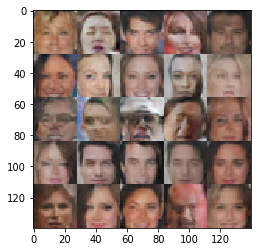

Epoch 8/100... Discriminator Loss: 1.1520... Generator Loss: 0.8744
Epoch 8/100... Discriminator Loss: 1.3002... Generator Loss: 0.7996
Epoch 8/100... Discriminator Loss: 1.2852... Generator Loss: 0.7495
Epoch 8/100... Discriminator Loss: 1.1874... Generator Loss: 0.7842
Epoch 8/100... Discriminator Loss: 1.2864... Generator Loss: 0.7852


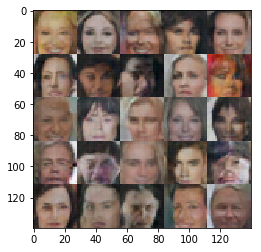

Epoch 9/100... Discriminator Loss: 1.2781... Generator Loss: 0.7455
Epoch 9/100... Discriminator Loss: 1.2447... Generator Loss: 0.8050
Epoch 9/100... Discriminator Loss: 1.3171... Generator Loss: 0.7186
Epoch 9/100... Discriminator Loss: 1.2987... Generator Loss: 0.7623
Epoch 9/100... Discriminator Loss: 1.3908... Generator Loss: 0.7043


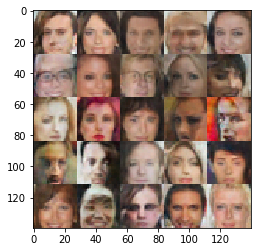

Epoch 9/100... Discriminator Loss: 1.3218... Generator Loss: 0.8073
Epoch 10/100... Discriminator Loss: 1.2596... Generator Loss: 0.8489
Epoch 10/100... Discriminator Loss: 1.1798... Generator Loss: 0.8307
Epoch 10/100... Discriminator Loss: 1.2438... Generator Loss: 0.7821
Epoch 10/100... Discriminator Loss: 1.2655... Generator Loss: 0.7420


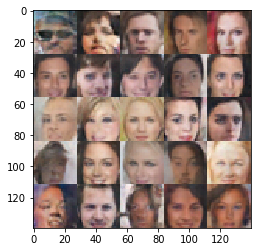

Epoch 10/100... Discriminator Loss: 1.3464... Generator Loss: 0.7143
Epoch 10/100... Discriminator Loss: 1.2450... Generator Loss: 0.7760
Epoch 10/100... Discriminator Loss: 1.1654... Generator Loss: 0.9039
Epoch 11/100... Discriminator Loss: 1.2715... Generator Loss: 0.7436
Epoch 11/100... Discriminator Loss: 1.2173... Generator Loss: 0.8774


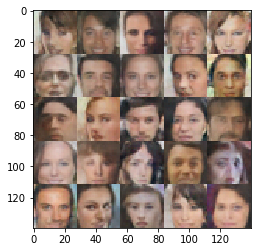

Epoch 11/100... Discriminator Loss: 1.3488... Generator Loss: 0.7185
Epoch 11/100... Discriminator Loss: 1.3830... Generator Loss: 0.6913
Epoch 11/100... Discriminator Loss: 1.3019... Generator Loss: 0.7453
Epoch 11/100... Discriminator Loss: 1.2163... Generator Loss: 0.8870
Epoch 12/100... Discriminator Loss: 1.2123... Generator Loss: 0.8373


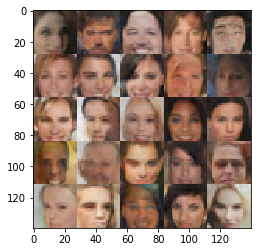

Epoch 12/100... Discriminator Loss: 1.3888... Generator Loss: 0.7395
Epoch 12/100... Discriminator Loss: 1.2648... Generator Loss: 0.8707
Epoch 12/100... Discriminator Loss: 1.2802... Generator Loss: 0.7673
Epoch 12/100... Discriminator Loss: 1.3488... Generator Loss: 0.6706
Epoch 12/100... Discriminator Loss: 1.3281... Generator Loss: 0.7426


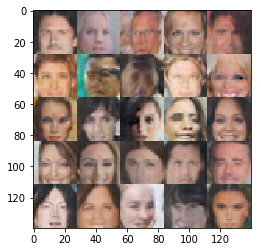

Epoch 13/100... Discriminator Loss: 1.1978... Generator Loss: 0.8986
Epoch 13/100... Discriminator Loss: 1.2680... Generator Loss: 0.7339
Epoch 13/100... Discriminator Loss: 1.3581... Generator Loss: 0.8736
Epoch 13/100... Discriminator Loss: 1.2509... Generator Loss: 0.8734
Epoch 13/100... Discriminator Loss: 1.2451... Generator Loss: 0.8609


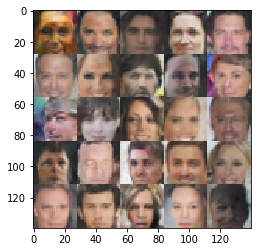

Epoch 13/100... Discriminator Loss: 1.2826... Generator Loss: 0.8016
Epoch 13/100... Discriminator Loss: 1.2241... Generator Loss: 0.7877
Epoch 14/100... Discriminator Loss: 1.1506... Generator Loss: 0.9991
Epoch 14/100... Discriminator Loss: 1.2870... Generator Loss: 0.8563
Epoch 14/100... Discriminator Loss: 1.3250... Generator Loss: 0.8191


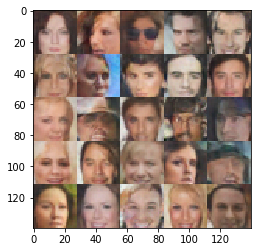

Epoch 14/100... Discriminator Loss: 1.1960... Generator Loss: 0.7404
Epoch 14/100... Discriminator Loss: 1.1551... Generator Loss: 0.8937
Epoch 14/100... Discriminator Loss: 1.2225... Generator Loss: 0.8066
Epoch 15/100... Discriminator Loss: 1.3590... Generator Loss: 0.6911
Epoch 15/100... Discriminator Loss: 1.1632... Generator Loss: 0.8495


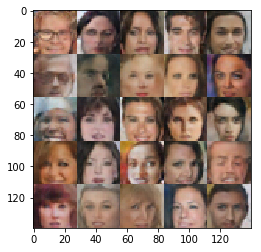

Epoch 15/100... Discriminator Loss: 1.2406... Generator Loss: 0.8321
Epoch 15/100... Discriminator Loss: 1.2211... Generator Loss: 0.7497
Epoch 15/100... Discriminator Loss: 1.2508... Generator Loss: 0.8497
Epoch 15/100... Discriminator Loss: 1.2229... Generator Loss: 0.8222
Epoch 16/100... Discriminator Loss: 1.2438... Generator Loss: 0.7330


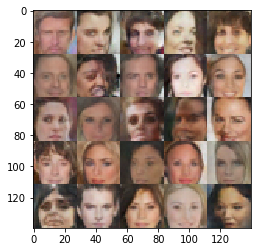

Epoch 16/100... Discriminator Loss: 1.1028... Generator Loss: 0.9344
Epoch 16/100... Discriminator Loss: 1.2581... Generator Loss: 0.8885
Epoch 16/100... Discriminator Loss: 1.3107... Generator Loss: 0.7248
Epoch 16/100... Discriminator Loss: 1.2829... Generator Loss: 0.7432
Epoch 16/100... Discriminator Loss: 1.1803... Generator Loss: 0.8302


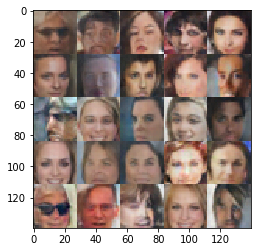

Epoch 16/100... Discriminator Loss: 1.2674... Generator Loss: 0.7719
Epoch 17/100... Discriminator Loss: 1.2934... Generator Loss: 0.7745
Epoch 17/100... Discriminator Loss: 1.3227... Generator Loss: 0.6348
Epoch 17/100... Discriminator Loss: 1.1631... Generator Loss: 0.9973
Epoch 17/100... Discriminator Loss: 1.2748... Generator Loss: 0.8026


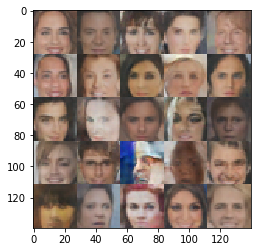

Epoch 17/100... Discriminator Loss: 1.1850... Generator Loss: 0.8334
Epoch 17/100... Discriminator Loss: 1.1394... Generator Loss: 0.8412
Epoch 18/100... Discriminator Loss: 1.3308... Generator Loss: 0.6978
Epoch 18/100... Discriminator Loss: 1.2417... Generator Loss: 0.7818
Epoch 18/100... Discriminator Loss: 1.1223... Generator Loss: 0.9230


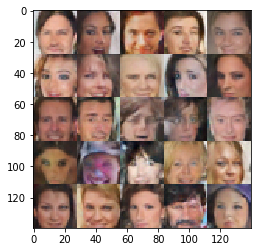

Epoch 18/100... Discriminator Loss: 1.2107... Generator Loss: 0.8607
Epoch 18/100... Discriminator Loss: 1.2273... Generator Loss: 0.8646
Epoch 18/100... Discriminator Loss: 1.2458... Generator Loss: 0.8556
Epoch 19/100... Discriminator Loss: 1.2002... Generator Loss: 0.8488
Epoch 19/100... Discriminator Loss: 1.2972... Generator Loss: 0.9813


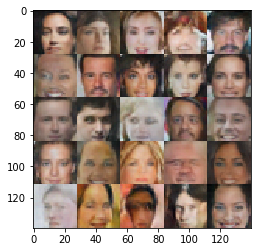

Epoch 19/100... Discriminator Loss: 1.2443... Generator Loss: 0.8315
Epoch 19/100... Discriminator Loss: 1.2220... Generator Loss: 0.6724
Epoch 19/100... Discriminator Loss: 1.1996... Generator Loss: 0.9144
Epoch 19/100... Discriminator Loss: 1.2757... Generator Loss: 0.8357
Epoch 19/100... Discriminator Loss: 1.2184... Generator Loss: 0.7825


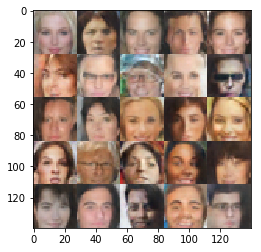

Epoch 20/100... Discriminator Loss: 1.1385... Generator Loss: 0.9967
Epoch 20/100... Discriminator Loss: 1.2783... Generator Loss: 0.7808
Epoch 20/100... Discriminator Loss: 1.2191... Generator Loss: 0.8301
Epoch 20/100... Discriminator Loss: 1.3132... Generator Loss: 0.8375
Epoch 20/100... Discriminator Loss: 1.2722... Generator Loss: 0.7924


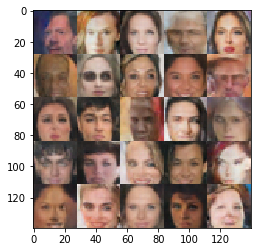

Epoch 20/100... Discriminator Loss: 1.2142... Generator Loss: 0.9300
Epoch 21/100... Discriminator Loss: 1.1232... Generator Loss: 0.9369
Epoch 21/100... Discriminator Loss: 1.1963... Generator Loss: 1.0112
Epoch 21/100... Discriminator Loss: 1.2341... Generator Loss: 0.6967
Epoch 21/100... Discriminator Loss: 1.2733... Generator Loss: 0.8501


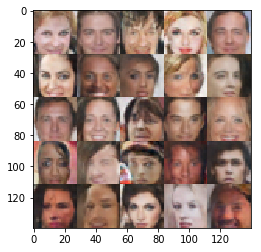

Epoch 21/100... Discriminator Loss: 1.2754... Generator Loss: 0.7513
Epoch 21/100... Discriminator Loss: 1.1888... Generator Loss: 0.8961
Epoch 22/100... Discriminator Loss: 1.0735... Generator Loss: 0.9772
Epoch 22/100... Discriminator Loss: 1.2741... Generator Loss: 0.7182
Epoch 22/100... Discriminator Loss: 1.1902... Generator Loss: 0.8097


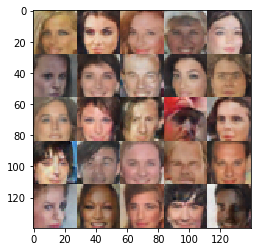

Epoch 22/100... Discriminator Loss: 1.1364... Generator Loss: 0.9738
Epoch 22/100... Discriminator Loss: 1.2622... Generator Loss: 0.8609
Epoch 22/100... Discriminator Loss: 1.1240... Generator Loss: 1.0253
Epoch 22/100... Discriminator Loss: 1.3294... Generator Loss: 0.6476
Epoch 23/100... Discriminator Loss: 1.1404... Generator Loss: 0.8100


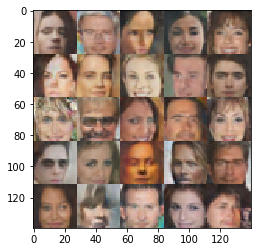

Epoch 23/100... Discriminator Loss: 1.2309... Generator Loss: 0.7459
Epoch 23/100... Discriminator Loss: 1.2141... Generator Loss: 0.8705
Epoch 23/100... Discriminator Loss: 1.1983... Generator Loss: 0.8419
Epoch 23/100... Discriminator Loss: 1.2529... Generator Loss: 0.7194
Epoch 23/100... Discriminator Loss: 1.2287... Generator Loss: 0.8714


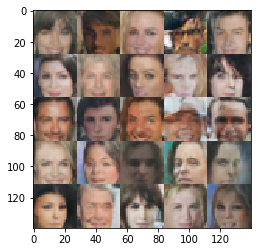

Epoch 24/100... Discriminator Loss: 1.1808... Generator Loss: 0.8682
Epoch 24/100... Discriminator Loss: 1.2470... Generator Loss: 0.8036
Epoch 24/100... Discriminator Loss: 1.2445... Generator Loss: 0.8416
Epoch 24/100... Discriminator Loss: 1.3508... Generator Loss: 0.7669
Epoch 24/100... Discriminator Loss: 1.2210... Generator Loss: 0.9420


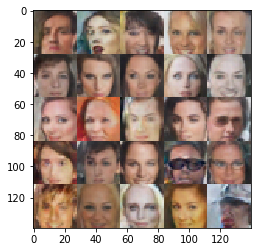

Epoch 24/100... Discriminator Loss: 1.1428... Generator Loss: 0.8178
Epoch 25/100... Discriminator Loss: 1.1544... Generator Loss: 0.9031
Epoch 25/100... Discriminator Loss: 1.2627... Generator Loss: 0.7756
Epoch 25/100... Discriminator Loss: 1.1272... Generator Loss: 1.0533
Epoch 25/100... Discriminator Loss: 1.3113... Generator Loss: 0.6980


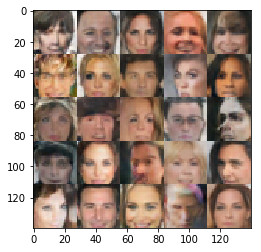

Epoch 25/100... Discriminator Loss: 1.1768... Generator Loss: 0.9168
Epoch 25/100... Discriminator Loss: 1.1687... Generator Loss: 0.7390
Epoch 25/100... Discriminator Loss: 1.2325... Generator Loss: 0.7773
Epoch 26/100... Discriminator Loss: 1.1748... Generator Loss: 0.9258
Epoch 26/100... Discriminator Loss: 1.1981... Generator Loss: 0.9416


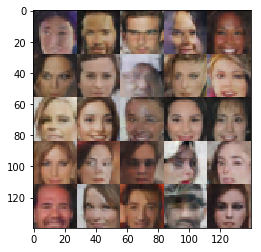

Epoch 26/100... Discriminator Loss: 1.0830... Generator Loss: 0.8780
Epoch 26/100... Discriminator Loss: 1.1596... Generator Loss: 0.8717
Epoch 26/100... Discriminator Loss: 1.2431... Generator Loss: 0.9088
Epoch 26/100... Discriminator Loss: 1.4563... Generator Loss: 0.7155
Epoch 27/100... Discriminator Loss: 1.2026... Generator Loss: 0.8516


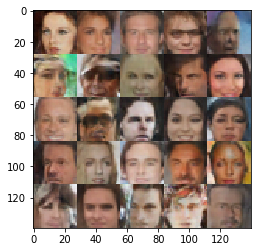

Epoch 27/100... Discriminator Loss: 1.1593... Generator Loss: 0.9295
Epoch 27/100... Discriminator Loss: 1.1232... Generator Loss: 0.8232
Epoch 27/100... Discriminator Loss: 1.2671... Generator Loss: 0.7850
Epoch 27/100... Discriminator Loss: 1.2347... Generator Loss: 0.8074
Epoch 27/100... Discriminator Loss: 1.2379... Generator Loss: 0.8122


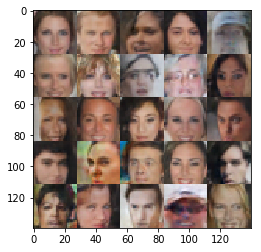

Epoch 28/100... Discriminator Loss: 1.1296... Generator Loss: 0.9714
Epoch 28/100... Discriminator Loss: 1.2673... Generator Loss: 0.8269
Epoch 28/100... Discriminator Loss: 1.2389... Generator Loss: 0.7968
Epoch 28/100... Discriminator Loss: 1.0991... Generator Loss: 0.9212
Epoch 28/100... Discriminator Loss: 1.1239... Generator Loss: 1.0180


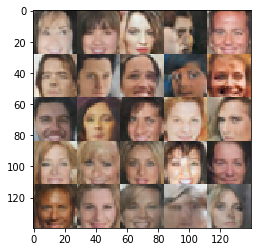

Epoch 28/100... Discriminator Loss: 1.2411... Generator Loss: 0.7633
Epoch 28/100... Discriminator Loss: 1.2694... Generator Loss: 0.7230
Epoch 29/100... Discriminator Loss: 1.2134... Generator Loss: 0.8448
Epoch 29/100... Discriminator Loss: 1.2694... Generator Loss: 0.6915
Epoch 29/100... Discriminator Loss: 1.2844... Generator Loss: 0.8416


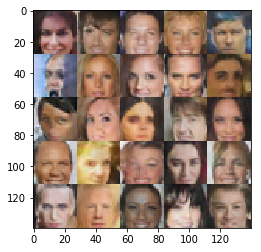

Epoch 29/100... Discriminator Loss: 1.2402... Generator Loss: 0.7851
Epoch 29/100... Discriminator Loss: 1.1364... Generator Loss: 0.8826
Epoch 29/100... Discriminator Loss: 1.2378... Generator Loss: 0.8371
Epoch 30/100... Discriminator Loss: 1.1832... Generator Loss: 0.8497
Epoch 30/100... Discriminator Loss: 1.1456... Generator Loss: 0.9849


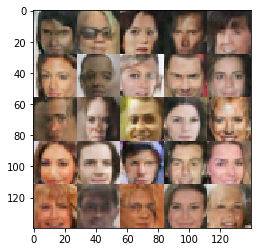

Epoch 30/100... Discriminator Loss: 1.2696... Generator Loss: 0.8414
Epoch 30/100... Discriminator Loss: 1.2011... Generator Loss: 0.8844
Epoch 30/100... Discriminator Loss: 1.1221... Generator Loss: 0.9509
Epoch 30/100... Discriminator Loss: 1.2338... Generator Loss: 0.9893
Epoch 31/100... Discriminator Loss: 1.1724... Generator Loss: 0.9085


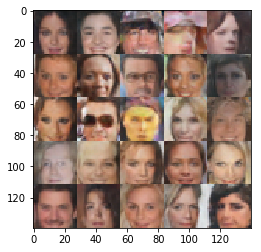

Epoch 31/100... Discriminator Loss: 1.1325... Generator Loss: 1.1481
Epoch 31/100... Discriminator Loss: 1.2491... Generator Loss: 0.8223
Epoch 31/100... Discriminator Loss: 1.1828... Generator Loss: 0.8128
Epoch 31/100... Discriminator Loss: 1.2081... Generator Loss: 0.9502
Epoch 31/100... Discriminator Loss: 1.1819... Generator Loss: 0.7867


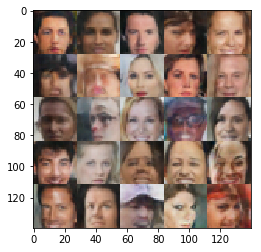

Epoch 31/100... Discriminator Loss: 1.0947... Generator Loss: 0.9470
Epoch 32/100... Discriminator Loss: 1.2433... Generator Loss: 0.7956
Epoch 32/100... Discriminator Loss: 1.2000... Generator Loss: 0.8086
Epoch 32/100... Discriminator Loss: 1.3193... Generator Loss: 0.8636
Epoch 32/100... Discriminator Loss: 1.0818... Generator Loss: 1.0630


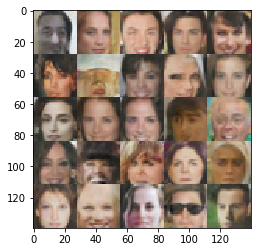

Epoch 32/100... Discriminator Loss: 1.1944... Generator Loss: 0.8535
Epoch 32/100... Discriminator Loss: 1.0688... Generator Loss: 1.1678
Epoch 33/100... Discriminator Loss: 1.1870... Generator Loss: 0.9278
Epoch 33/100... Discriminator Loss: 1.1677... Generator Loss: 0.8441
Epoch 33/100... Discriminator Loss: 1.1984... Generator Loss: 0.9577


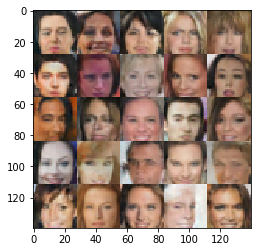

Epoch 33/100... Discriminator Loss: 1.2494... Generator Loss: 0.7959
Epoch 33/100... Discriminator Loss: 1.2176... Generator Loss: 0.8167
Epoch 33/100... Discriminator Loss: 1.1323... Generator Loss: 0.9284
Epoch 34/100... Discriminator Loss: 1.1611... Generator Loss: 0.8890
Epoch 34/100... Discriminator Loss: 1.2461... Generator Loss: 0.7906


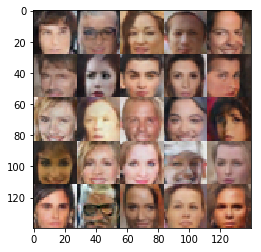

Epoch 34/100... Discriminator Loss: 1.1985... Generator Loss: 0.7576
Epoch 34/100... Discriminator Loss: 1.0919... Generator Loss: 0.9812


In [ ]:
batch_size = 64 #needs to be a factor of 4096
z_dim = 100
learning_rate = 0.001
beta1 = 0.6

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 100

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

__Note:__ I have also run this upto 50 epochs on AWS and that gave sharper and better outputs.  This is from the roughly 1 GB GPU that I have on my local machine, but I'm happy it already shows imaged in under 10 epochs ( even 1 epoch shows images that are recognizable as faces, but the quality does seem to improve with more epochs ).  

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.